# Import dataset

In [1]:
# Imports

# activate interactive mode of pd.dataframe
import pandas as pd
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

import os

import json
from tqdm import tqdm
import numpy as np
import itertools

import tensorflow as tf

#pytorch model
import torch
import torch.nn.functional as F
import torch.nn as nn

import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import animation
from pathlib import Path
import IPython
from IPython import display
from IPython.core.display import display, HTML, Javascript
from IPython.display import Markdown as md

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2


## Libraries Used
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

2023-09-04 12:21:42.803022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 12:21:53.843394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_4304/4162441623.py:34: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [2]:
# Config

class Cfg:
    INPUT_ROOT = Path('./asl-signs/')
    OUTPUT_ROOT = Path('./output_analysis/')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'
    
LANDMARK_FILES_DIR = "./asl-signs/train_landmark_files"
label_map = json.load(open("./asl-signs/sign_to_prediction_index_map.json", "r"))

train_df = pd.read_csv("./gislr-extended-train-dataframe/extended_train.csv")
train_df['label'] = train_df['sign'].map(label_map)

In [3]:
# Helpers

ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# https://www.kaggle.com/code/ted0071/gislr-visualization
def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result    

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data[train_data.sequence_id == sequence_id]['path'].item()
    return read_landmark_data_by_path(file_path)

In [4]:
train_df.shape

(94477, 22)

In [5]:
print(f"Кількість зразків у датасеті - {train_df.shape[0]}")
print(f"Кількість класів у датасеті - {250}")

Кількість зразків у датасеті - 94477
Кількість класів у датасеті - 250


# Anasysis columns

In [6]:
train_df

path  participant_id  \
0      /kaggle/input/asl-signs/train_landmark_files/2...           26734   
1      /kaggle/input/asl-signs/train_landmark_files/2...           28656   
2      /kaggle/input/asl-signs/train_landmark_files/1...           16069   
3      /kaggle/input/asl-signs/train_landmark_files/2...           25571   
4      /kaggle/input/asl-signs/train_landmark_files/6...           62590   
...                                                  ...             ...   
94472  /kaggle/input/asl-signs/train_landmark_files/5...           53618   
94473  /kaggle/input/asl-signs/train_landmark_files/2...           26734   
94474  /kaggle/input/asl-signs/train_landmark_files/2...           25571   
94475  /kaggle/input/asl-signs/train_landmark_files/2...           29302   
94476  /kaggle/input/asl-signs/train_landmark_files/3...           36257   

       sequence_id    sign  start_frame  end_frame  total_frames  face_count  \
0       1000035562    blow           20         42            23       10764   
1       1000106739    wait           29         39            11        5148   
2        100015657   cloud          103        207           105       49140   
3       1000210073    bird           17         28            12        5616   
4       1000240708    owie           22         39            18        8424   
...            ...     ...          ...        ...           ...         ...   
94472    999786174   white           64        112            49       22932   
94473    999799849    have           36         41             6        2808   
94474    999833418  flower            1         37            37       17316   
94475    999895257    room            9         42            34       15912   
94476    999962374   happy           97        129            33       15444   

       face_nan_count  pose_count  ...  left_hand_nan_count  right_hand_count  \
0                   0         759  ...                  483               483   
1                   0         363  ...                  231               231   
2                   0        3465  ...                 1617              2205   
3                   0         396  ...                  252               252   
4                   0         594  ...                  378               378   
...               ...         ...  ...                  ...               ...   
94472               0        1617  ...                 1029              1029   
94473               0         198  ...                  126               126   
94474               0        1221  ...                  777               777   
94475               0        1122  ...                  714               714   
94476               0        1089  ...                    0               693   

       right_hand_nan_count     x_min     x_max     y_min     y_max     z_min  \
0                       252 -0.031811  1.294350 -2.147826 -0.224151 -2.782624   
1                       189 -0.017062  1.015931 -2.222732 -0.329273 -2.543970   
2                      2205 -0.042923  1.197836 -2.591290 -0.248094 -2.838325   
3                         0 -0.129268  1.156573 -2.294936 -0.310272 -3.018237   
4                         0  0.072425  1.165405 -2.264609 -0.405282 -2.970331   
...                     ...       ...       ...       ...       ...       ...   
94472                   546  0.031721  1.183957 -2.561170 -0.297828 -3.287074   
94473                    84 -0.149159  1.310044 -2.170514 -0.177696 -2.678213   
94474                   294  0.057847  0.977379 -2.460778 -0.223186 -3.220553   
94475                   588 -0.045806  0.985802 -2.081611 -0.325751 -2.036529   
94476                   693 -0.279641  1.144231 -2.419790 -0.156502 -3.006498   

          z_max  label  
0      1.910815     25  
1      1.627621    232  
2      1.587503     48  
3      2.196296     23  
4      1.360011    164  
...         ...    ...  
94472  2.400607    238  
94473  1.494088    108  
94474  

### Аналіз колонок у файлі extended_train.csv
<em>Загальна інформація</em>
* path - шлях до файлу з екземпляром певного жесту
* participant_id - унікальний номер учасника, який виконував цей жест
* sequence_id - унікальний номер певного екземпляру жеста
* sign - назва жесту
* label - унікальний номер для класу цього жесту

<em>Інформація про фрейми</em>
* start_frame - фрейм, з якого починає певний учасник відтворювати даний жест(у файлі з цим жестом нормер фрейму починається з цього номера)
* end_frame - номер фрейма на якому закінчується даний жест
* total_frame - загальна кількість фреймів, яка знадобилася щоб відтворити цей екземпляр жесту

<em>Інформація про типи точок</em>
* face_count - кількість точок лиця, яка присутня у файлі з відтворенням цього жеста
* face_nan_count - кількість відсутніх точок для визначення лиця
* pose_count - кількість точок тулуба, яка присутня у файлі з відтворенням цього жеста
* pose_nan_count - кількість відсутніх точкох для визначення тулуба
* left_hand_count - кількість точок лівої руки, яка присутня у файлі з відтворенням цього жеста
* left_hand_nan_count - кількість відсутніх точок для визначення лівої руки
* right_hand_count - кількість точок правої руки, яка присутня у файлі з відтворенням цього жеста
* right_hand_nan_count - кількість відсутніх точок для визначення правої руки

<em>Інформація про координати</em>
* x_min - найменший координат х для цього екземпляру
* x_max - найменший координат х для цього екземпляру
* y_min - найменший координат х для цього екземпляру
* y_max - найменший координат х для цього екземпляру
* z_min - найменший координат х для цього екземпляру
* z_max - найменший координат х для цього екземпляру

In [7]:
id_ = 1011655866
train = pd.read_csv(Cfg.TRAN_FILE)
data = read_landmark_data_by_id(id_, train)
data

frame        type  landmark_index         x         y  \
row_id                                                                    
23-face-0            23        face               0  0.381393  0.377334   
23-face-1            23        face               1  0.387510  0.333088   
23-face-2            23        face               2  0.384334  0.349668   
23-face-3            23        face               3  0.377555  0.302792   
23-face-4            23        face               4  0.388338  0.322209   
...                 ...         ...             ...       ...       ...   
39-right_hand-16     39  right_hand              16       NaN       NaN   
39-right_hand-17     39  right_hand              17       NaN       NaN   
39-right_hand-18     39  right_hand              18       NaN       NaN   
39-right_hand-19     39  right_hand              19       NaN       NaN   
39-right_hand-20     39  right_hand              20       NaN       NaN   

                         z  
row_id                      
23-face-0        -0.045009  
23-face-1        -0.060799  
23-face-2        -0.037500  
23-face-3        -0.038101  
23-face-4        -0.062246  
...                    ...  
39-right_hand-16       NaN  
39-right_hand-17       NaN  
39-right_hand-18       NaN  
39-right_hand-19       NaN  
39-right_hand-20       NaN  

[9231 rows x 6 columns]

### Аналіз колонок в файлі певного екземпляра
* row_id - унікальна назва точки яка складається з <номер_фрейма>-<тип_точки>-<номер_точки>
* frame - номер фрейму
* type - тип точки(лице, тулуб, права або ліва рука)
* landmark_index - номер точки (кількість точок для кожного типу: face-468, left_hand-21, pose-33, right_hand-21)
* x -координата х
* y - координата у
* z - координата z

# Anasysis Metadata

<em> Цей розділ присвячується пошуку розподілів та аналіз даних </em>


---

## Розполіл між класами

In [8]:
meta_data_df = train_df.groupby('sign').agg({'sequence_id': 'count',
                                             'total_frames': 'sum'})
meta_data_df.columns = ['num_seq','num_frames']
meta_data_df['avg_frames'] = np.round(meta_data_df['num_frames']/meta_data_df['num_seq'])

meta_data_df

num_seq  num_frames  avg_frames
sign                                      
TV             385       14197        37.0
after          347       10546        30.0
airplane       393       17274        44.0
all            386       14090        37.0
alligator      390       18021        46.0
...            ...         ...         ...
yesterday      398       15705        39.0
yourself       385       13499        35.0
yucky          379       14190        37.0
zebra          375       14399        38.0
zipper         299        9750        33.0

[250 rows x 3 columns]

In [9]:
print(f"Середня кількість еклемплярів класу: {int(meta_data_df.num_seq.sum()/250)}")
print(f"Середня кількість фреймів для класу: {int(meta_data_df.avg_frames.sum()/250)}")

Середня кількість еклемплярів класу: 377
Середня кількість фреймів для класу: 37


In [10]:
fig = go.Figure()

cols_name = meta_data_df.columns.values.tolist()
colors = ["#0F9D58","#4285F4","#F4B400"]

for color,col in zip(colors,cols_name):
    # store tmp df
    tmp = meta_data_df.sort_values(col)
    fig.add_trace(go.Bar(x=tmp.index, 
                         y=tmp[col],
                         width=0.5,name=col,marker_color=color))

fig.update_layout(
    title={
            'text': "ISL Розподіл",
            'font': dict(size=20,family="Georgia",color=colors[1]),
            'y':0.87,
            'x':0.035,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 4000,
    xaxis=dict(title='Знак', fixedrange=True),
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
  
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.005,
            xanchor="right",
            y=1.2,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True,True]},
                           {"title": "ISL Розподіл",
                            "legend":True,
                            }]),
                dict(label="Sequences",
                     method="update",
                     args=[{"visible": [True, False,False]},
                           {"title": "Розподіл кількості екземплярів для кожного класу",
                            "legend":True,
                            }]),
                dict(label="Frames",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Розподіл кількості фреймів для кожного класу",
                            "legend":True,
                            }]),
                dict(label="Avg frames",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Розподіл середньої кількості фреймів для кожного класу",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

In [11]:
fig = go.Figure()

cols_name = meta_data_df.columns.values.tolist()
colors = ["#0F9D58","#4285F4","#F4B400", "#0F9D58","#4285F4","#F4B400"]

for color,col in zip(colors,cols_name):
    # store tmp df
    tmp = meta_data_df.sort_values(col)[::-1][:10]
    fig.add_trace(go.Bar(x=tmp.index, 
                         y=tmp[col],
                         width=0.5,name=col,marker_color=color))
    
for color,col in zip(colors,cols_name):
    # store tmp df
    tmp = meta_data_df.sort_values(col)[:10][::-1]
    fig.add_trace(go.Bar(x=tmp.index, 
                         y=tmp[col],
                         width=0.5,name=col,marker_color=color))

fig.update_layout(
    title={
            'text': "ISL Розподіл",
            'font': dict(size=20,family="Georgia",color=colors[1]),
            'y':0.87,
            'x':0.5,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 1200,
    xaxis=dict(title='Знак', fixedrange=True),
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
  
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.005,
            xanchor="right",
            y=1.2,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="10 класів з найбільшою кількістю екземплярів",
                     method="update",
                     args=[{"visible": [True, False, False, False, False, False]},
                           {"title": "10 класів з найбільшою кількістю екземплярів",
                            "legend":True,
                            }]),
                dict(label="10 класів з найбільшою кількістю фреймів",
                     method="update",
                     args=[{"visible": [False,True, False, False, False, False]},
                           {"title": "10 класів з найбільшою кількістю фреймів",
                            "legend":True,
                            }]),
                dict(label="10 класів з найбільшою середньої кількістю фреймів",
                     method="update",
                     args=[{"visible": [False, False,True, False, False, False]},
                           {"title": "10 класів з найбільшою середньої кількістю фреймів",
                            "legend":True,
                            }]),
                
                dict(label="10 класів з найменшою кількістю екземплярів",
                     method="update",
                     args=[{"visible": [False, False, False, True, False,False]},
                           {"title": "10 класів з найменшою кількістю екземплярів",
                            "legend":True,
                            }]),
                dict(label="10 класів з найменшою кількістю фреймів",
                     method="update",
                     args=[{"visible": [False, False, False, False,True, False]},
                           {"title": "10 класів з найменшою кількістю фреймів",
                            "legend":True,
                            }]),
                dict(label="10 класів з найменшою середньою кількістю фреймів",
                     method="update",
                     args=[{"visible": [False, False, False, False, False,True]},
                           {"title": "10 класів з найменшою середньою кількістю фреймів",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

In [12]:
import plotly.graph_objects as go
import numpy as np

colors = ['blueviolet', 'lightseagreen', 'chocolate']

fig = go.Figure()
for color,col in zip(colors,cols_name):
    fig.add_trace(go.Box(y=meta_data_df[col],
                         name=col, marker_color=color))
    

fig.update_layout(
    title={
            'text': "ISL Розподіл",
            'font': dict(size=20,family="Georgia",color="black"),
            'y':0.87,
            'x':0.35,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=0,
    width= 800,
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
  
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.005,
            xanchor="right",
            y=1.2,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="Розподіл кількісті екземплярів",
                     method="update",
                     args=[{"visible": [True, False, False]},
                           {"title": "Розподіл кількості екземплярів для кожного класу",
                            "legend":True,
                            }]),
                dict(label="Розподіл кількісті фреймів",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Розподіл кількісті фреймів для кожного класу",
                            "legend":True,
                            }]),
                dict(label="Розподіл середньої кількістю фреймів",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Розподіл середньої кількістю фреймів для кожного класу",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

### Деякі висновки:


* Кількість екземплярів для кожного класу в середньму 380. Клас з найбільшою кількістю екземплярів 415(listen). Клас з найменшою кількістю екземплярів - 299(zipper).
* В основному кількість екземплярів розподілена між 369 до 391. Але також є викиди, класи у яких кількість екземплярів менша за квартилі.


* У середньому на знак припадає 377 послідовностей і 37 кадрів на послідовність.



* Знак «mitten» має найбільшу кількість кадрів і середнє число кадрів на послідовність 


## Розподіл між учасниками

Кожний жест здійснював не один учасник, наступне дослідження присвяченне розподілу кількості екземплярів класів для кожного з учасників.

In [13]:
participant_level_df = train_df.groupby(['participant_id','sign']).agg({'sequence_id': 'count',
                                                                        'total_frames': 'sum'})
participant_level_df['avg_frames'] = np.round(participant_level_df.total_frames/participant_level_df.sequence_id)
participant_level_df.columns = ['num_seq','num_frames','avg_frames']
participant_level_df = participant_level_df.reset_index()
participant_level_df

participant_id       sign  num_seq  num_frames  avg_frames
0               2044         TV       20         295        15.0
1               2044      after       22         215        10.0
2               2044   airplane       19         407        21.0
3               2044        all       19         283        15.0
4               2044  alligator       20         530        26.0
...              ...        ...      ...         ...         ...
5225           62590  yesterday       19         385        20.0
5226           62590   yourself       19         543        29.0
5227           62590      yucky       18         641        36.0
5228           62590      zebra       19         676        36.0
5229           62590     zipper       17         285        17.0

[5230 rows x 5 columns]

In [14]:
print(f"Кількість учасників - {participant_level_df.participant_id.nunique()}") 
print(f"Середня кількість екземплярів на учасника - {int(participant_level_df.num_seq.sum()/participant_level_df.participant_id.nunique())}") 

Кількість учасників - 21
Середня кількість екземплярів на учасника - 4498


In [15]:
fig = go.Figure()

cols_name = participant_level_df.columns.values.tolist()[2:]
colors = ["#0F9D58","#4285F4","#F4B400"]
methods = ['sum','sum','sum']

for color,col,method in zip(colors,cols_name,methods):
    # store tmp series object
    tmp = participant_level_df.groupby(['participant_id'])\
                              .agg({col: method})[col]\
                              .sort_values(ascending=False)
    fig.add_trace(go.Bar(x=tmp.index.astype('str'), 
                         y=tmp.values,
                         width=0.8,name=col,marker_color=color))
fig.update_layout(
    title={
            'text': "Розподіл між учасниками",
            'font': dict(size=20,family="Georgia",color="black"),
            'y':0.87,
            'x':0.35,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 800,
    height=500,
    xaxis=dict(title='ID Учасника', fixedrange=True),
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
    
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.01,
            xanchor="right",
            y=1.20,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True,True]},
                           {"title": "Розподіл між учасниками",
                            "legend":True,
                            }]),
                dict(label="Sequences",
                     method="update",
                     args=[{"visible": [True, False,False]},
                           {"title": "Розподіл кількості екземлярів для кожного учасниками",
                            "legend":True,
                            }]),
                dict(label="Frames",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Розподіл кількості фреймів для кожного учасника",
                            "legend":True,
                            }]),
                dict(label="Avg frames",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Розподіл середньої кількості фреймів для кожного учасника",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

In [16]:
fig = go.Figure()

cols_name = participant_level_df.columns.values.tolist()[2:]
colors = ["#0F9D58","#4285F4","#F4B400"]
methods = ['sum','sum','sum']

for color,col,method in zip(colors,cols_name,methods):
    # store tmp series object
    tmp = participant_level_df.groupby(['participant_id'])\
                              .agg({col: method})[col]\
                              .sort_values(ascending=False)
    fig.add_trace(go.Box(y=tmp.values,
                         width=0,name=col,marker_color=color))
fig.update_layout(
    title={
            'text': "Розподіл між учасниками",
            'font': dict(size=20,family="Georgia",color="black"),
            'y':0.87,
            'x':0.18,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=0,
    width= 800,
    height=500,
    xaxis=dict(title='ID Учасника', fixedrange=True),
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
    
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.01,
            xanchor="right",
            y=1.20,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="Sequences",
                     method="update",
                     args=[{"visible": [True, False,False]},
                           {"title": "Розподіл кількості екземлярів для кожного учасниками",
                            "legend":True,
                            }]),
                dict(label="Frames",
                     method="update",
                     args=[{"visible": [False,True, False]},
                           {"title": "Розподіл кількості фреймів для кожного учасника",
                            "legend":True,
                            }]),
                dict(label="Avg frames",
                     method="update",
                     args=[{"visible": [False, False,True]},
                           {"title": "Розподіл середньої кількості фреймів для кожного учасника",
                            "legend":True,
                            }]),
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

### Деякі висновки:

* Загальна кількість учасників, які приймали участь у створенні цього датасету - 21
* 3 учасники мають найменшу кількість послідовностей
* Учасник ID-49445 має найбільшу кількість кадрів, тоді як учасник ID-37779 має найменшу кількість кадрів
* У середньому на одного учасника припадає 4498 послідовностей

# Відносність між різними типами точок

<em> У цьому розділі представлено яке відстокове співвідношення між різними типами точко(точки які нажелать позі, лицю чи рукам). Скільки null значень.</em>

---

In [17]:
train = pd.read_csv(Cfg.TRAN_FILE)

In [18]:
df_null_by_sign = pd.DataFrame(columns = ["sign", "face_null", "left_hand_null", "pose_null", "right_hand_null"])
signs = list(train.sign.unique())

for i, sign in enumerate(tqdm(signs)):
    data = [pd.read_parquet(Cfg.INPUT_ROOT / f) for f in train[train.sign == sign].path]
    merged_data = pd.concat(data,ignore_index=True)
    
    
    sample_left_hand = merged_data[merged_data.type == "left_hand"]
    sample_right_hand = merged_data[merged_data.type == "right_hand"]
    sample_pose = merged_data[merged_data.type == "pose"]
    sample_face = merged_data[merged_data.type == "face"]


    df_null_by_sign.loc[i] = [sign, 100*np.mean(sample_face['x'].isnull()), 100*np.mean(sample_left_hand['x'].isnull()),
                              100*np.mean(sample_pose['x'].isnull()), 100*np.mean(sample_right_hand['x'].isnull())]

100%|███████████████████████████████████████| 250/250 [1:27:58<00:00, 21.11s/it]


In [19]:
df_null_by_sign = df_null_by_sign.set_index('sign')

In [20]:
fig = go.Figure()

cols_name = df_null_by_sign.columns.values.tolist()
colors = ["#ffff57","#b3ff57","#57aeff", "#c891ff"]

for color,col in zip(colors,cols_name):
    # store tmp df
    tmp = df_null_by_sign.sort_values(col)[::-1]
    fig.add_trace(go.Bar(x=tmp.index, 
                         y=tmp[col],
                         width=0.5,name=col,marker_color=color))
    

fig.update_layout(
    title={
            'text': "Відсоток null значень",
            'font': dict(size=20,family="Georgia",color="black"),
            'y':0.87,
            'x':0.5,
            'xanchor': 'left',
            'yanchor': 'top'},
    template="plotly_white",
    xaxis_tickangle=-45,
    width= 1200,
    xaxis=dict(title='Знак', fixedrange=True),
    yaxis=dict(title='Кількість',fixedrange=True),
    showlegend=True,
  
    updatemenus=[
        dict(
            # customize dropdown
            active=0,
            direction="down",
            pad={"r": 50, "t": 25},
            showactive=True,
            x=0.005,
            xanchor="right",
            y=1.2,
            yanchor="top",
            
            # customize button
            buttons=list([
                dict(label="Face",
                     method="update",
                     args=[{"visible": [True, False, False, False]},
                           {"title": "Відсоток null значень для типу точок face",
                            "legend":True,
                            }]),
                dict(label="Left hand",
                     method="update",
                     args=[{"visible": [False,True, False, False]},
                           {"title": "Відсоток null значень для типу точок left hand",
                            "legend":True,
                            }]),
                dict(label="Pose",
                     method="update",
                     args=[{"visible": [False, False,True, False]},
                           {"title": "Відсоток null значень для типу точок pose",
                            "legend":True,
                            }]),
                
                dict(label="Right hand",
                     method="update",
                     args=[{"visible": [False, False, False, True]},
                           {"title": "Відсоток null значень для типу точок right hand",
                            "legend":True,
                            }]),
                
            ]),
        ),
    ])

fig.show(config= dict(displayModeBar = False))

In [21]:
df_null_by_sign

face_null  left_hand_null  pose_null  right_hand_null
sign                                                           
blow       2.557191       68.985866        0.0        69.940259
wait       0.376506       72.502510        0.0        67.689508
cloud      0.697255       71.499720        0.0        68.928594
bird       2.159172       65.750654        0.0        60.129669
owie       0.104405       69.539967        0.0        72.156607
...             ...             ...        ...              ...
elephant   3.529941       71.797946        0.0        78.715431
after      0.692206       75.251280        0.0        78.238195
car        0.063224       75.321391        0.0        75.223042
hide       0.077353       78.203696        0.0        73.820370
goose      2.153997       60.344640        0.0        68.382594

[250 rows x 4 columns]

### Деякі висновки:

* Тип точок pose ніколи не має null значень
* Face має не велику кількість null значень, це повязна з перекриванням швидше за все рукою лице і зменшенням кількості розпізнаваних точок
* Точки left hand частіше відсутні ніж right hand. Також клас у якому мало присутніх точок певної руки, не збігаються з іншою. Отже, для багатьох символів потрібно задіювати лише одну руку, що і утворюює велику кількість null для іншої. 

# Landmarks Analysis

<em> Цей розділ містить візуалізацію даних, як вони представленні через Mediapipe </em>

---

In [22]:
sign_table = {}
for i in range(10):
    sign_table[f'{i}'] = train_df.sign.unique()[i*10:i*10+25].tolist()
sign_table = pd.DataFrame(sign_table)
sign_table

0        1            2            3            4            5  \
0     blow   vacuum       zipper         shoe       hungry          bad   
1     wait    apple        clean          wet       orange          can   
2    cloud   puzzle       closet          see         milk          say   
3     bird   mitten        quiet        empty           go  callonphone   
4     owie    there         have         fall       drawer       finish   
5     duck      dry      brother      balloon           TV          old   
6   minemy    shirt        clown  frenchfries      another     backyard   
7     lips      owl        cheek       finger      giraffe         sick   
8   flower   yellow         cute         same         wake         look   
9     time      not        store          cry          bee         that   
10  vacuum   zipper         shoe       hungry          bad        black   
11   apple    clean          wet       orange          can     yourself   
12  puzzle   closet          see         milk          say         open   
13  mitten    quiet        empty           go  callonphone    alligator   
14   there     have         fall       drawer       finish         moon   
15     dry  brother      balloon           TV          old         find   
16   shirt    clown  frenchfries      another     backyard        pizza   
17     owl    cheek       finger      giraffe         sick         shhh   
18  yellow     cute         same         wake         look         fast   
19     not    store          cry          bee         that       jacket   
20  zipper     shoe       hungry          bad        black     scissors   
21   clean      wet       orange          can     yourself          now   
22  closet      see         milk          say         open          man   
23   quiet    empty           go  callonphone    alligator       sticky   
24    have     fall       drawer       finish         moon         jump   

            6         7        8         9  
0       black  scissors     fish       sad  
1    yourself       now   cowboy      face  
2        open       man     snow     penny  
3   alligator    sticky    dryer      gift  
4        moon      jump    green     night  
5        find     sleep      bug      hair  
6       pizza       sun      nap       who  
7        shhh     first     feet     think  
8        fast     grass    yucky     brown  
9      jacket     uncle  morning       mad  
10   scissors      fish      sad       bed  
11        now    cowboy     face     drink  
12        man      snow    penny      stay  
13     sticky     dryer     gift      flag  
14       jump     green    night     tooth  
15      sleep       bug     hair     awake  
16        sun       nap      who  thankyou  
17      first      feet    think       hot  
18      grass     yucky    brown      like  
19      uncle   morning      mad     where  
20       fish       sad      bed   hesheit  
21     cowboy      face    drink     potty  
22       snow     penny     stay      down  
23      dryer      gift     flag     stuck  
24      green     night    tooth        no

In [23]:
#Function for create visualisation

#function for output one type point(pose, hand or face)
def plot_frame_one_type(df, type_, landmarks, name, ax):
    x = list(df.x)
    y = list(df.y)
    
    
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))
        
    ax.title.set_size(20)
    
    if landmarks == None:
        ax.scatter(df.x, df.y, color='navy')
        ax.title.set_text(f"{name}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:     
        ax.scatter(df.x, df.y, color='black')
        for edge in landmarks:
            ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='navy')
            ax.title.set_text(f"{name}")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

#function for output all type points
def plot_all_types(df, frame, name_sign):
    mpl.style.use('seaborn-v0_8')
    df_frame = df[df.frame == frame]
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    fig.suptitle(f'Назва жесту: {name_sign}, Номер кадру {frame}', fontsize=25)
    name_label = ['Лице', 'Ліва рука', 'Поза', 'Права рука']
    landmarks = [None, hand_landmarks, pose_landmarks, hand_landmarks]
    for type_, i, landmark, name in zip(data.type.unique(), range(4), landmarks, name_label):
        plot_frame_one_type(df_frame[df_frame.type == type_], type_, landmark, name, ax[i%2][i//2])
        
    plt.show()

#function for output hand landmark
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

#function for output pose points
def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

#function for animation frame with all points
def animation_frame(f):
    mpl.style.use('default')
    frame = data[data.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    ax.axis('off')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i], color='navy')
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i], color='navy')
    for i in range(len(px)):
        ax.plot(px[i], py[i], color='navy')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

In [24]:
#Chose correct id for output pose

id_ = 1011655866
data = read_landmark_data_by_id(id_, train)
data.y = data.y * -1

In [25]:
print(f"All different types of landmark = {data.type.unique()}")

All different types of landmark = ['face' 'left_hand' 'pose' 'right_hand']


![Hand Landmarks](hand_landmarks.png)

In [26]:
hand_landmarks = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

![Pose Landmarks](68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f706f73655f747261636b696e675f66756c6c5f626f64795f6c616e646d61726b732e706e67.png)

In [27]:
pose_landmarks = [(0,1),(1,2),(2,3),(0,4),(4,5),(5,6),(3,7),(6,8),(9,10), 
                  (11,12),(11,13),(12,14),(13,15),(14,16),(15,17),(16,18),
                  (17,19),(18,20),(19,15),(20,16),(15,21),(16,22),(11,23),
                  (12,24),(23,24),(24,26),(26,28),(28,30),(30,32),(32,28),
                  (23,25),(25,27),(27,31),(31,29),(29,27)]

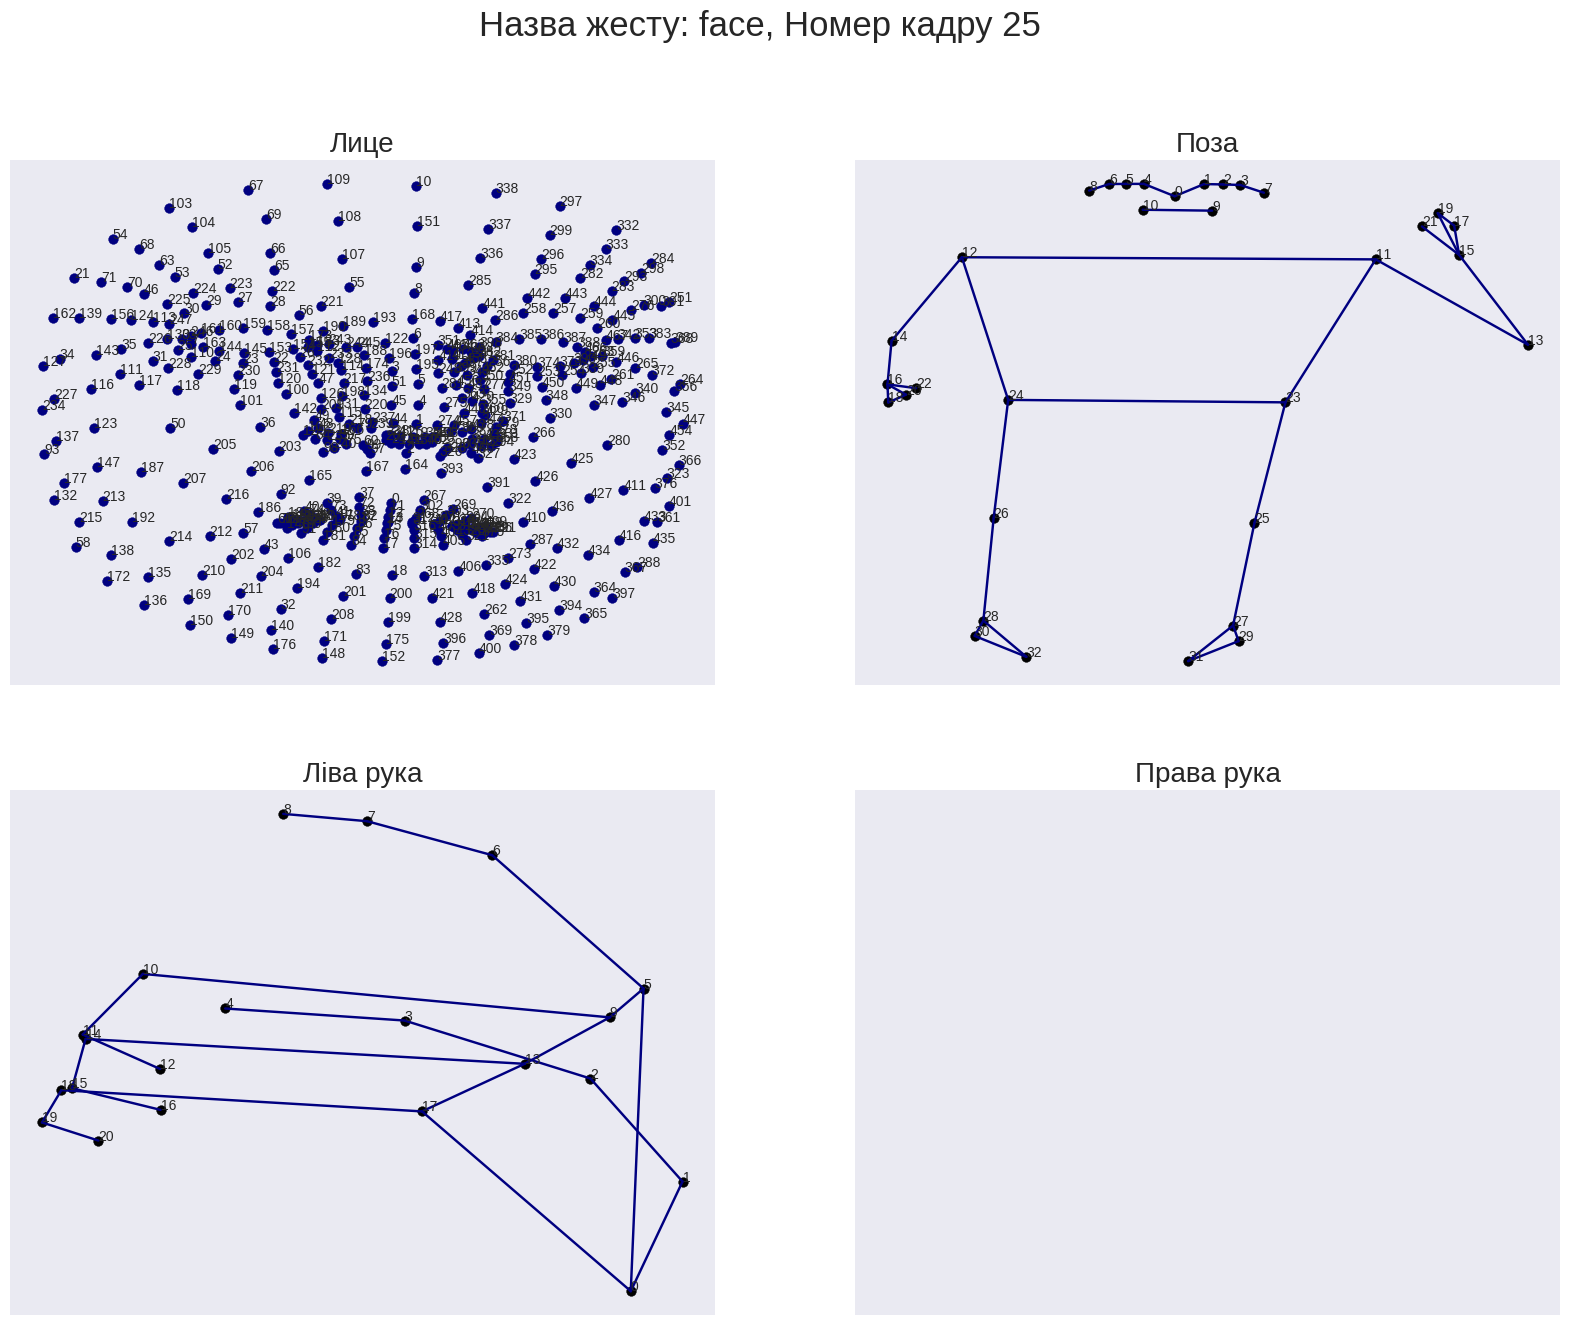

In [28]:
plot_all_types(df = data, frame = 25, name_sign = train[train.path.str.contains('1011655866')].sign.values[0])        

The sign being shown here is: face


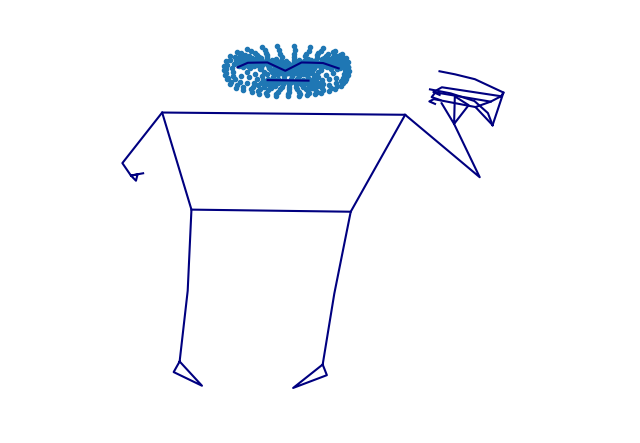

In [29]:
print(f"The sign being shown here is: {train[train.path.str.contains(str(id_))].sign.values[0]}")

## These values set the limits on the graph to stabilize the video
xmin = data.x.min() - 0.2
xmax = data.x.max() + 0.2
ymin = data.y.min() - 0.2
ymax = data.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=data.frame.unique())

HTML(animation.to_html5_video())